# AB Multi-arm Star-shaped Polymers in Potential Fields

This script demonstrates how to compute single partition functions and concentrations of AB multi-arm star-shaped polymers for given potential fields.

### 1. Import python modules and set environment variables

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import polymerfts

# OpenMP environment variables
os.environ["MKL_NUM_THREADS"] = "1"  # always 1
os.environ["OMP_STACKSIZE"] = "1G"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"  # 0, 1
os.environ["OMP_NUM_THREADS"] = "2"  # 1 ~ 4

# GPU environment variables
os.environ["LFTS_GPU_NUM_BLOCKS"]  = "256"
os.environ["LFTS_GPU_NUM_THREADS"] = "256"
os.environ["LFTS_NUM_GPUS"] = "1" # 1 ~ 2

### 2. Setup some simulation parameters

\begin{align}
N &= 100 \\
\Delta s &= 1/N = 0.01 \\
L_x &= 5.0 bN^{1/2} \\
L_y &= 5.0 bN^{1/2} \\
V &= L_x L_y \\ 
m_x &= 64 \\
m_y &= 64 \\
b_A/b &= 1.0 \\
b_B/b &= 1.0 \\  
\end{align}

In numerical computation, $b^2N = 1$.

In [2]:
# Simulation parameters
nx = [64,64]                       # grid number
lx = [5.0,5.0]                     # box size
stat_seg_lengths = {"A":1.0,       # statistical segment lengths
                    "B":1.0}        

ds = 0.01                          # contour step interval

### 3. Create a Factory

* The factory will create the following instances for chosen platform and data-type.
    * simulation_box
    * molecules
    * propagator_computation_optimizer
    * solver

In [3]:
# Select platform ("cuda" or "cpu-mkl") and data-type ("real" or "complex")
reduce_gpu_memory_usage = False
factory = polymerfts.PlatformSelector.create_factory("cpu-mkl", reduce_gpu_memory_usage, "real")
factory.display_info()

==================== MKL Version ====================
Major version:           2021
Minor version:           0
Update version:          4
Product status:          Product
Build:                   20210904
Platform:                Intel(R) 64 architecture
Processor optimization:  Intel(R) Architecture processors


In [4]:
# Create an instance for computation box
cb = factory.create_computation_box(nx, lx) 
# Create an instance for molecule information with block segment information and chain model ("continuous" or "discrete")
molecules = factory.create_molecules_information("continuous", ds, stat_seg_lengths)

### 4. Add AB 3-arm star-shaped polymers, where each arm is diblock copolymer with $f_A = 0.7$ and $f_B = 0.3$

In [5]:
# Add AB diblock copolymers
volume_fraction = 1.0
blocks = [["A", 0.7, 0, 1], ["B", 0.3, 1, 4],
          ["A", 0.7, 0, 2], ["B", 0.3, 2, 5],
          ["A", 0.7, 0, 3], ["B", 0.3, 3, 6],
          ]
molecules.add_polymer(volume_fraction, blocks)

### 5. Analyze graphs and optimize the computations.

Remove the redundent computations and aggregate propagators of multiple side chains.

References: [Dynamic Programming for Chain Propagator Computation of Branched Block Copolymers in Polymer Field Theory Simulations](https://doi.org/10.1021/acs.jctc.5c00103)

In [6]:
# Optimizer to avoid redundant computations
aggregate_propagator_computation = True
propagator_computation_optimizer = factory.create_propagator_computation_optimizer(molecules, aggregate_propagator_computation)
propagator_computation_optimizer.display_blocks()
propagator_computation_optimizer.display_propagators()

--------------- Blocks ---------------
Polymer id, left key:
	aggregated, (left, right) is_junction, (left, right) n_segment, right key, n_repeat, {v, u} list

0, (B30)A:
	 X, (O, O), (70, 70), ((B30)A70(B30)A70)A, 3, {1,0}, {2,0}, {3,0}

0, B:
	 X, (X, O), (30, 30), (((B30)A70(B30)A70)A70)B, 3, {4,1}, {5,2}, {6,3}
--------------- Propagators ---------------
Key:
	height, aggregated, max_n_segment, # dependencies, junction_ends
B:
	 0, X, 30, 0, {30}, 
(B30)A:
	 1, X, 70, 1, {70}, 
((B30)A70(B30)A70)A:
	 2, X, 70, 2, {70}, 
(((B30)A70(B30)A70)A70)B:
	 3, X, 30, 1, {}, 
Total number of modified diffusion equation steps (time complexity) to compute propagators: 600
Total number of steps after optimizing computation : 200
Computational cost reduction (higher is better) : 66.67 %


### 5. Set Potential Fields

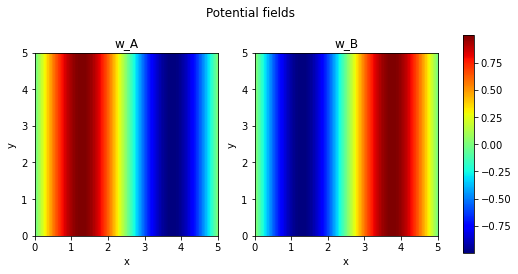

In [7]:
w_A =  np.tile(np.sin(np.linspace(0, 2*np.pi, nx[0])), (nx[1], 1))   # sinusoidal potential field for A
w_B = -np.tile(np.sin(np.linspace(0, 2*np.pi, nx[0])), (nx[1], 1))   # sinusoidal potential field for B
w = {"A": w_A, "B": w_B}  # potential field dictionary

# Plot each image with the same vmin and vmax
vmin = min(w_A.min(), w_B.min())
vmax = max(w_A.max(), w_B.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Potential fields")
im = axes[0].imshow(w_A, extent=(0, lx[0], 0, lx[1]), origin='lower', cmap=cm.jet, vmin=vmin, vmax=vmax)
im = axes[1].imshow(w_B, extent=(0, lx[0], 0, lx[1]), origin='lower', cmap=cm.jet, vmin=vmin, vmax=vmax)
axes[0].set(title='w_A', xlabel='x', ylabel='y')
axes[1].set(title='w_B', xlabel='x', ylabel='y')

fig.subplots_adjust(right=1.0)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.show()

### 6. Solving the modified diffusion equations and compute single chain partition function

The propagators for A-type block, $(v,t) \in \{(0,1),(0,2),(0,3),(3,0),(2,0),(3,0)\}$ :
\begin{align}
\left[-\frac{\partial}{\partial s} + \frac{b_A^2}{6}\nabla^2 - w_A({\bf r})\right] q^{v \rightarrow t}_0({\bf r}, s)=0,\ \ \ \ \ s\in [0, f_A]
\end{align}

The propagators for B-type block, $(v,t) \in \{(1,4),(2,5),(3,6),(4,1),(5,2),(6,3)\}$ :
\begin{align}
\left[-\frac{\partial}{\partial s} + \frac{b_B^2}{6}\nabla^2 - w_B({\bf r})\right] q^{v \rightarrow t}_0({\bf r}, s)=0,\ \ \ \ \ s\in [0, f_B]
\end{align}

Single chain partition function:
\begin{align}
Q_0 = \frac{1}{V}\int d{\bf r}\ q^{0 \rightarrow 1}_0({\bf r}, s)q^{1 \rightarrow 0}_0({\bf r}, f_A-s) 
\end{align}

In [8]:
# Create a solver
solver = factory.create_pseudospectral_solver(cb, molecules, propagator_computation_optimizer)

# Compute Propagators (q) and single partition function (Q)
solver.compute_propagators({"A":w["A"], "B":w["B"]})

# Single partition function
Q = solver.get_total_partition(0)
print(f"Q:", Q)

Q: 1.4050690258393599


### 7. Compute Concentrations

\begin{align}
\phi_A({\bf r}) &= \frac{1}{Q_0} \sum_{(v,t)\in\{(0,1),(0,2),(0,3)\}} \int_{0}^{f_A} ds\ q^{v \rightarrow t}_0({\bf r}, s)q^{t \rightarrow v}_0({\bf r}, f_A-s) \\
\phi_B({\bf r}) &= \frac{1}{Q_0} \sum_{(v,t)\in\{(1,4),(2,5),(3,6)\}} \int_{0}^{f_B} ds\ q^{v \rightarrow t}_0({\bf r}, s)q^{t \rightarrow v}_0({\bf r}, f_B-s) 
\end{align}

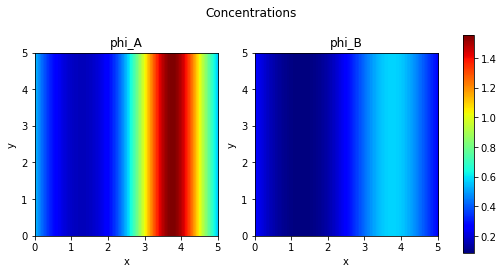

In [9]:
# Compute ensemble average concentration (phi)
solver.compute_concentrations()

# Get the ensemble average concentration for each monomer type
phi_A = np.reshape(solver.get_total_concentration("A"), nx)
phi_B = np.reshape(solver.get_total_concentration("B"), nx)

# Plot each image with the same vmin and vmax
vmin = min(phi_A.min(), phi_B.min())
vmax = max(phi_A.max(), phi_B.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Concentrations")
im = axes[0].imshow(phi_A, extent=(0, lx[0], 0, lx[1]), origin='lower', cmap=cm.jet, vmin=vmin, vmax=vmax)
im = axes[1].imshow(phi_B, extent=(0, lx[0], 0, lx[1]), origin='lower', cmap=cm.jet, vmin=vmin, vmax=vmax)
axes[0].set(title='phi_A', xlabel='x', ylabel='y')
axes[1].set(title='phi_B', xlabel='x', ylabel='y')

fig.subplots_adjust(right=1.0)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.show()